In [5]:
import h5py as hp
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbs
from aps_figures.aps_one_column import *
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
N_SEGMENTS = 416
SIGMA_Y = 9.820578e-06
FOLDER = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/'
# FOLDER = '/home/gubaidulin/Data/Data_sumo/Gaps_SOLEIL/'
n_macroparticles = 1e4
n_macroparticles_ions = 1e6
n_gaps = 4
gap_length = 1
n_segments = 25
# FOLDER += 'n_mp={:.1e},n_mp_ions={:.1e},n_gaps={:.1e},n_segments={:.1e}_every_104/'.format(n_macroparticles, n_macroparticles_ions, n_gaps, n_segments)
FOLDER += 'n_mp={:.1e},gap_length={:},n_gaps={:},n_segments={:},int_model=weak,smooth=True/'.format(
                                                                                                              n_macroparticles,
                                                                                                              # n_macroparticles_ions,
                                                                                                              gap_length,
                                                                                                              n_gaps,
                                                                                                              n_segments)
# FOLDER += 'n_mp={:.1e},n_mp_ions={:.1e},gap_length={:.1e},n_gaps={:},n_segments={:.1e},int_model=strong,smooth=True/'.format(n_macroparticles, n_macroparticles_ions, gap_length, int(n_gaps), n_segments)
# FOLDER += 'n_mp={:.1e},n_mp_ions={:.1e},n_gaps={:.1e},n_segments={:.1e}_every_104,int_model=strong/'.format(n_macroparticles, n_macroparticles_ions, n_gaps, n_segments)
# FOLDER += 'n_mp={:.1e},n_mp_ions={:.1e},n_gaps={:.1e}/'.format(n_macroparticles, n_macroparticles_ions, n_gaps)
def read_bunch(bunch_number, n_macroparticles):
    filename = FOLDER+'BM(n_bunch={:}).h5'.format(bunch_number)
    # filename = FOLDER+'BM_n={:}.h5'.format(bunch_number)
    file = hp.File(filename)
    mean_x = file['Bunch']['mean_x'][:]
    sigma_x = file['Bunch']['sigma_x'][:]
    mean_xp = file['Bunch']['mean_xp'][:]
    mean_y = file['Bunch']['mean_y'][:]
    sigma_y = file['Bunch']['sigma_y'][:]
    mean_yp = file['Bunch']['mean_yp'][:]
    mean_z = file['Bunch']['mean_z'][:] 
    mean_dp = file['Bunch']['mean_dp'][:]
    mean_x = np.trim_zeros(mean_x)
    mean_xp = np.trim_zeros(mean_xp)
    mean_y = np.trim_zeros(mean_y)
    mean_yp = np.trim_zeros(mean_yp)
    sigma_x = np.trim_zeros(sigma_x)
    sigma_y = np.trim_zeros(sigma_y)
    file.close()
    return mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp
def read_bunch_emittance(bunch_number):
    filename = FOLDER+'BM(n_bunch={:}).h5'.format(bunch_number)
    file = hp.File(filename)
    epsn_x = file['Bunch']['epsn_x'][:]
    epsn_y = file['Bunch']['epsn_y'][:] 
    epsn_x = np.trim_zeros(epsn_x)
    epsn_y = np.trim_zeros(epsn_y)
    file.close()
    return epsn_x, epsn_y
def read_ion_element(index):
    filename = FOLDER+'IM(ind={0:}).h5'.format(int(index))
    file = hp.File(filename)
    mean_x = file['Bunch']['mean_x'][:]
    sigma_x = file['Bunch']['sigma_x'][:]
    mean_xp = file['Bunch']['mean_xp'][:]
    mean_y = file['Bunch']['mean_y'][:]
    sigma_y = file['Bunch']['sigma_y'][:]
    mean_yp = file['Bunch']['mean_yp'][:]
    mean_z = file['Bunch']['mean_z'][:]
    mean_dp = file['Bunch']['mean_dp'][:]
    mean_x = np.trim_zeros(mean_x)
    mean_xp = np.trim_zeros(mean_xp)
    mean_y = np.trim_zeros(mean_y)
    mean_yp = np.trim_zeros(mean_yp)
    sigma_x = np.trim_zeros(sigma_x)
    sigma_y = np.trim_zeros(sigma_y)
    file.close()
    return mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp
def read_ion_particles(index, step):
    filename = FOLDER+'IPM(ind={0:}).h5part'.format(int(index))
    file = hp.File(filename)
    # for step in range(file['Step']['x'][:])
    mean_x = file['Step#{:}'.format(step)]['x'][:]
    mean_xp = file['Step#{:}'.format(step)]['xp'][:]
    mean_y = file['Step#{:}'.format(step)]['y'][:]
    mean_yp = file['Step#{:}'.format(step)]['yp'][:]
    mean_z = file['Step#{:}'.format(step)]['z'][:] 
    mean_dp = file['Step#{:}'.format(step)]['dp'][:]
    mean_x = np.trim_zeros(mean_x)
    mean_xp = np.trim_zeros(mean_xp)
    mean_y = np.trim_zeros(mean_y)
    mean_yp = np.trim_zeros(mean_yp)
    file.close()
    return mean_x, mean_xp, mean_y, mean_yp, mean_z, mean_dp

In [6]:
bunch_number =50
n_macropartices = int(1e3)
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)
epsn_x, epsn_y = read_bunch_emittance(bunch_number)
mean_x_ion, sigma_x_ion, mean_xp_ion, mean_y_ion, sigma_y_ion, mean_yp_ion, mean_z_ion, mean_dp_ion = read_ion_element(1)

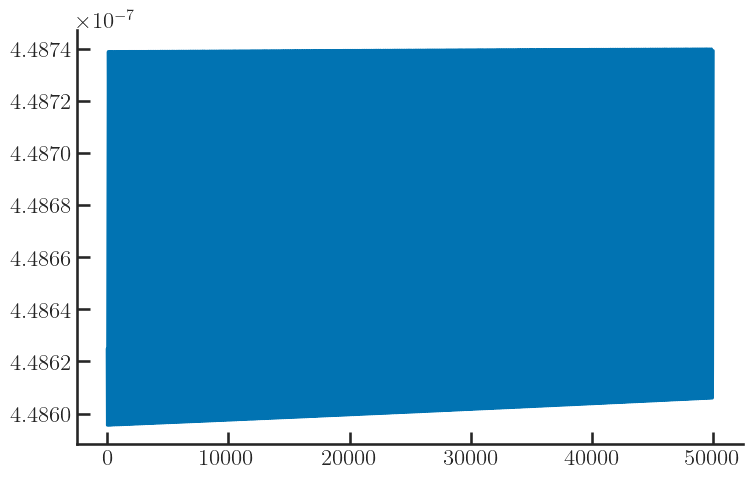

In [7]:
plt.plot(epsn_x)

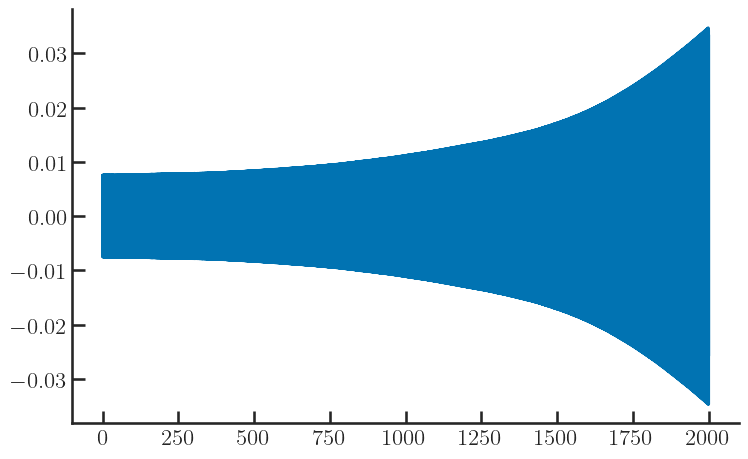

In [8]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.linspace(0, mean_y.shape[0]/25, mean_y.shape[0]), mean_y/sigma_y)
# ax.plot(epsn_y)

In [9]:
sig_x = np.mean(sigma_x_ion[:50])
sig_y = np.mean(sigma_y_ion[:50])
L_sep = 0.85
L_bunch=4*SIGMA_Z
def get_M_e(omega_i, L_sep=0.85, L_bunch=4*SIGMA_Z):
    omega_i_b = omega_i*np.sqrt(L_sep/L_bunch)
    phi_b = omega_i_b*L_bunch/c
    beta_b = c/omega_i_b
    M_e = np.array([[np.cos(phi_b), beta_b*np.sin(phi_b)], [-1/beta_b*np.sin(phi_b), np.cos(phi_b)]])
    return M_e 
@np.vectorize
def get_omega_i(sig_x, sig_y, A=28, intensity_per_bunch=int(1e9), L_sep=0.85):
    return c*np.sqrt(4*intensity_per_bunch*r_u/(3*L_sep*sig_x*(sig_y+sig_x)*A)), c*np.sqrt(4*intensity_per_bunch*r_u/(3*L_sep*sig_y*(sig_y+sig_x)*A))  
@np.vectorize
def get_omega_e(sigma_x, sigma_y, Sigma_I, n_g, N_e, gamma_r):
    return c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_x*(sigma_y+sigma_x))), c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_y*(sigma_y+sigma_x)))

omega_i_x, omega_i_y = get_omega_i(sig_x, sig_y, L_sep=L_sep, A=28, intensity_per_bunch=INTENSITY_PER_BUNCH)
sig_e_x, sig_e_y = sigma_x[0], sigma_y[0]
omega_e_x, omega_e_y = get_omega_e(sig_e_x, sig_e_y, Sigma_I=1.8e-22, n_g=3.6e12, N_e=INTENSITY_PER_BUNCH, gamma_r=GAMMA)

print('Bunch length in SOLEIL-II is {:.2f} metres'.format(L_bunch))
M_sep  = np.array([[1, L_sep],[0, 1]])
M_e = get_M_e(omega_i_y, L_sep=L_sep, L_bunch = L_bunch)
# print('Trapping condition for ions |{:.2f}| < 2'.format( np.trace(M_sep@M_e)) )
print('Ions are trapped', np.abs(np.trace(M_sep@M_e)) < 2)
print('Betatron tunes are {0:.1f}, {1:.1f}'.format(Q_X, Q_Y))
print('Ion bounce tunes are {0:.1f}, {1:.1f}'.format(omega_i_x/OMEGA_REV, omega_i_y/OMEGA_REV))
print('Electron bounce tunes are {0:.3f}, {1:.3f}'.format(omega_e_x/OMEGA_REV, omega_e_y/OMEGA_REV))
def get_t_of_bunch_n(n, omega_e, omega_i, L_sep):
    return 2*Q_Y*OMEGA_REV/(n**2*omega_e**2*omega_i*L_sep/c)
print('The predicted instability growth time for the simulation parameters is {:.2e} turns'.format(get_t_of_bunch_n(416, omega_e_y, omega_i_y, L_sep=0.85)*2*pi*OMEGA_REV))
print('Relativistic gamma is {:.1f}'.format(GAMMA))

Bunch length in SOLEIL-II is 0.01 metres
Ions are trapped True
Betatron tunes are 54.2, 18.3
Ion bounce tunes are 71.0, 102.7
Electron bounce tunes are 0.008, 0.011
The predicted instability growth time for the simulation parameters is 7.01e+00 turns
Relativistic gamma is 5382.6


In [10]:
from FIT_FBII import fit_exponential_risetime, fit_sqrt_exponential_risetime, get_envelope
from tqdm.notebook import tqdm
window_size = 35
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(0, n_macroparticles)
n_segments_n_turns = mean_y.shape[0]
n_turns = int(n_segments_n_turns/n_segments)
print(n_turns)
mean_y_beam = np.empty(shape=(int(H_RF*n_segments_n_turns),))
mean_yp_beam = np.empty(shape=(int(H_RF*n_segments_n_turns),))
max_mean_y = np.empty(shape=(H_RF,))
mean_y_init = np.empty(shape=(H_RF,))
risetime_exponential = np.empty(shape=(H_RF,))
risetime_sqrt = np.empty(shape=(H_RF,))
for bunch_number in tqdm(range(0,H_RF)):
    try:
        mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)
    # ax.scatter(bunch_number, np.max(mean_x[-100:])/sigma_x[0], marker='.', color='b')
        signal = np.sqrt(mean_y**2+(BETA_Y_SMOOTH*mean_yp)**2)/sigma_y[0]
        mean_y_beam[bunch_number::H_RF] = mean_y[::]
        max_mean_y[bunch_number] = np.max(mean_y)
        mean_y_init[bunch_number] = mean_y[0]

    # rx = fit_exponential_risetime(signal,
    #                           min_level=1.2*np.mean(np.abs(signal[:50])), 
    #                           smoothing_window_size=window_size, 
    #                           start_from_0=False,
    #                           matplotlib_axis = None
    #                          )
    # rx2 = fit_sqrt_exponential_risetime(signal,
    #                                 min_level=1.2*np.mean(np.abs(signal[:50])),
    #                                 start_from_0=False,
    #                                 smoothing_window_size=window_size, 
    #                                 matplotlib_axis = None
    #                                )
    # risetime_exponential[bunch_number] = rx/n_segments
    # risetime_sqrt[bunch_number] = rx2**2/n_segments
    except:
        risetime_exponential[bunch_number] = None
        risetime_sqrt[bunch_number] = None

2000


  0%|          | 0/416 [00:00<?, ?it/s]

1000.447161594792


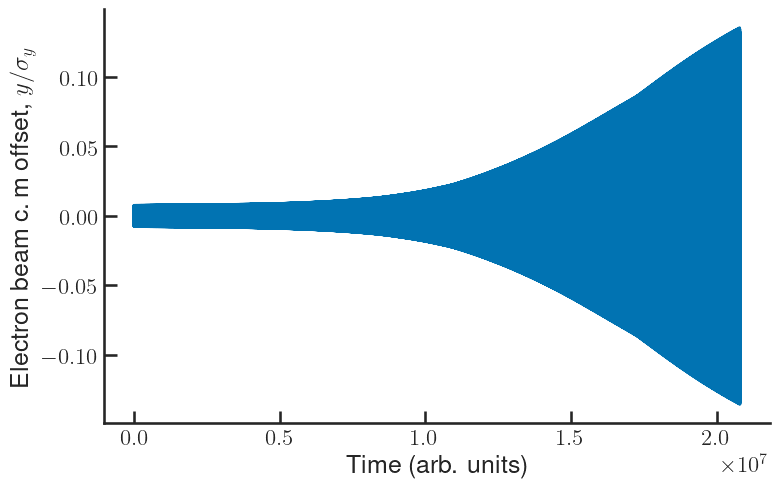

In [19]:
from scipy.signal import hilbert
fig, ax  = plt.subplots(1, 1)
signal = np.abs(hilbert(mean_y_beam/sigma_y[0]))
# turns = np.linspace(0, mean_y_beam.shape[0]/H_RF/n_segments, mean_y_beam.shape[0])
ax.plot(mean_y_beam[:]/sigma_y[0])
# ax.plot(signal)
rx = fit_exponential_risetime(signal,
                              min_level=0.002, 
                              smoothing_window_size=4000, 
                              start_from_0=True,
                              matplotlib_axis = None,
                             min_n_risetimes=0.1)
ax.set_ylabel('Electron beam c.$\,$m offset, $y/\sigma_y$')
ax.set_xlabel('Time (arb. units)')
print(rx/n_segments/H_RF)

(416,)
(416,)


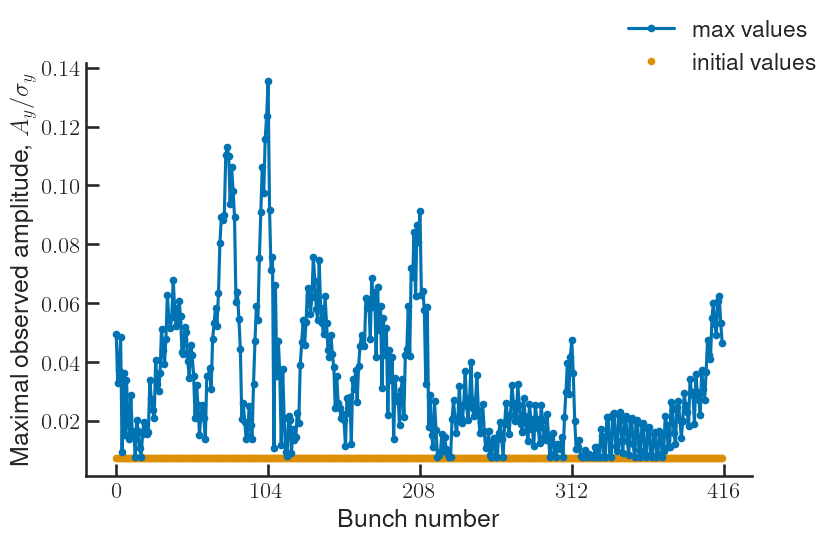

In [20]:
from FITX import fit_risetime
import os
fig, ax = plt.subplots(1, 1)
print(max_mean_y.shape)
ax.plot(range(0, 416), max_mean_y[:]/sigma_y[0], marker='.',  label='max values')
ax.plot(range(0, 416), mean_y_init[:]/sigma_y[0], marker='.', lw=0, zorder=0, label='initial values')
# signal = max_mean_y[:-45]/sigma_y[0]
# window_size = 20
# rx = fit_risetime(signal,
#                   min_level=0.05, 
#                   smoothing_window_size=window_size, 
#                   start_from_0=False,
#                   matplotlib_axis = ax
# )
# ax.set_ylim(1e-3, 1)
# ax.set_xlim(1, H_RF)
ax.set_ylabel('Maximal observed amplitude, $A_y/\sigma_y$')
ax.set_xticks([0, int(H_RF/4), int(2*H_RF/4), int(3*H_RF/4), H_RF])
ax.set_xlabel('Bunch number')
plt.figlegend()
# print(np.max(mean_y[-50:]))
np.save(FOLDER+'max_amplitudes', max_mean_y/sigma_y[0])
os.system('mkdir -p {:}'.format(FOLDER+'Figures'))
# ax.title.set_text('Two bucket gap')
plt.savefig(FOLDER+'Figures/amplitudes.svg')
plt.savefig(FOLDER+'Figures/amplitudes.pdf')
print(max_mean_y.shape)

(831584,)


(-0.25, 0.25)

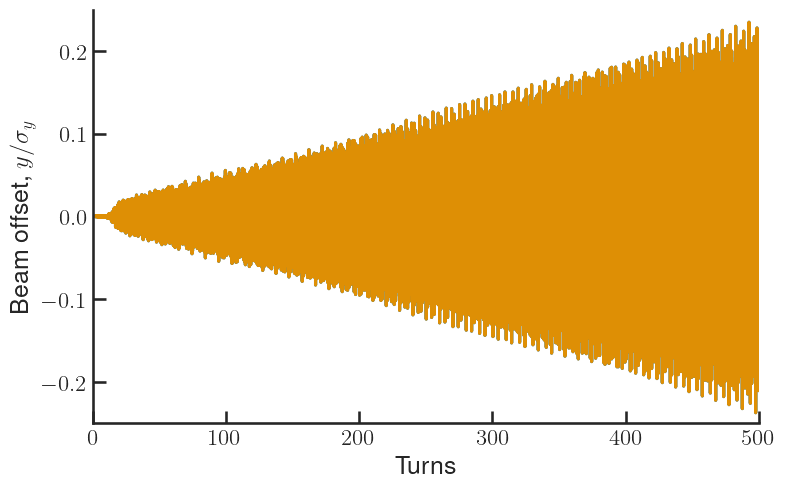

In [18]:
import h5py as hp
from aps_figures.aps_one_column import *
fig, ax = plt.subplots(1, 1)
for n in [1, ]:
    f = hp.File('/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/ion{:}beam.hdf5'.format(n))    
    Cy_array = []
    # print(f['page{:}'.format(int(page))]['columns']['Cy'][:].shape)
    for page in range(1, len(f.keys())):
        Cy_array = np.concatenate((Cy_array, (f['page{:}'.format(int(page))]['columns']['Cy'][:])))
    f.close()
    Cy_array = np.array(Cy_array)
    print(Cy_array.shape)
    turns = np.linspace(0, 2000, Cy_array.shape[0])
    ax.plot(turns, Cy_array/sigma_y[0])
    turns_el = np.linspace(0, 2000, Cy_array.shape[0])
    ax.plot(turns_el, Cy_array/sigma_y[0])
ax.set_ylabel('Beam offset, $y/\sigma_y$')
ax.set_xlabel('Turns')
ax.set_xlim(0, 500)
ax.set_ylim(-.25, .25)
# fig, ax = plt.subplots(1, 1)
# fft_Cy = np.fft.rfft(Cy_array)
# f_s = f_0*H_RF
# fft_freq_Cy = np.fft.rfftfreq(Cy_array.shape[0])
# ax.plot(f_s/f_0*fft_freq_Cy, np.abs(fft_Cy))

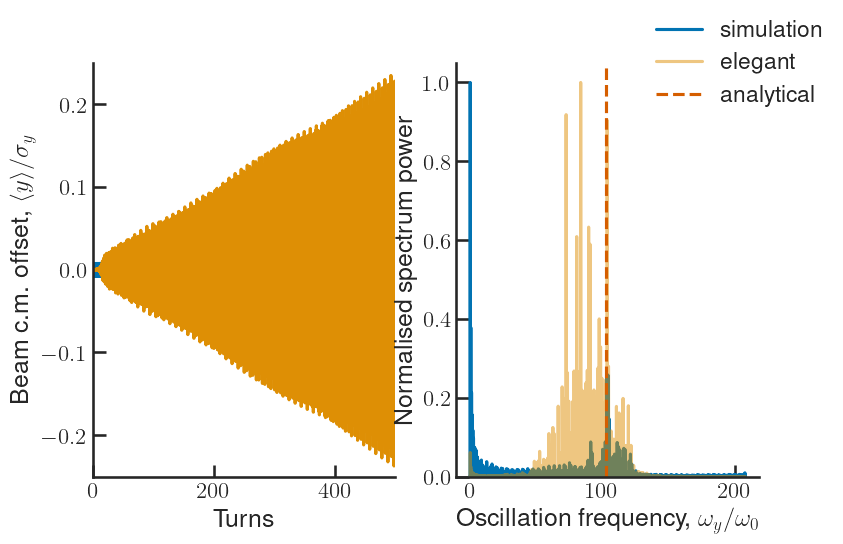

In [9]:
from aps_figures.aps_one_column import *
fig, axlist = plt.subplots(1, 2)
# fig, ax2 = plt.subplots(1, 1)
# axlist = [ax1, ax2]
# mean_y_beam = mean_y_beam[:130*50*H_RF]
turns = np.linspace(0, mean_y_beam.shape[0]/H_RF/n_segments, mean_y_beam.shape[0])
axlist[0].plot(turns, (mean_y_beam-np.mean(mean_y_beam))[:]/sigma_y[0])
fft_beam = np.abs(np.fft.rfft((mean_y_beam-np.mean(mean_y_beam))[:]))
f_0 = c/CIRCUMFERENCE
f_s = f_0*H_RF#*n_segments
fftfreq_beam = f_s*np.fft.rfftfreq(mean_y_beam[:].shape[0])
# fft_beam[:int(0.25*fft_beam.shape[0])] = 0
axlist[1].plot(fftfreq_beam/f_0, fft_beam/max(fft_beam), label='simulation')
axlist[0].set_ylabel('Beam c.m. offset, $\langle y \\rangle/\sigma_y$')
axlist[1].set_xlabel('Oscillation frequency, $\omega_y/\omega_0$')
axlist[1].set_ylabel('Normalised spectrum power')
np.save(FOLDER+'beam_offset', (mean_y_beam-np.mean(mean_y_beam))[:]/sigma_y[0])
axlist[1].set_ylim(0,)
# axlist[1].set_xlim(0,200)
axlist[0].set_xlim(0, 500)
axlist[0].set_ylim(-.25, .25)
turns_el = np.linspace(0, 2000, Cy_array.shape[0])
axlist[0].plot(turns_el, Cy_array/sigma_y[0])
axlist[0].set_xlabel('Turns')
fft_Cy = np.fft.rfft(Cy_array)
f_s_el = f_0*H_RF
fft_freq_Cy = np.fft.rfftfreq(Cy_array.shape[0])
axlist[1].plot(f_s_el/f_0*fft_freq_Cy, np.abs(fft_Cy)/np.max(np.abs(fft_Cy)), label='elegant', alpha=0.5)
# axlist[0].title.set_text('Beam offset')
# axlist[1].title.set_text('Electron beam power spectrum')
axlist[1].axvline(omega_i_y/OMEGA_REV, linestyle='dashed', color='r', label='analytical')
plt.figlegend()
plt.savefig('/home/gubaidulin/Pictures/work/BII_instability_example.pdf')
plt.savefig('/home/gubaidulin/Pictures/work/BII_instability_example.svg')

In [10]:
f = hp.File('/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/ion{:}fft.hdf5'.format(1))    
    # Cy_array = []
page=1
fftCy = (f['page{:}'.format(int(page))]['columns']['FFTCy'][:])
fftfreqCy = (f['page{:}'.format(int(page))]['columns']['f'][:])
# for page in range(1, len(f.keys())):
    # Cy_array = np.concatenate((Cy_array, (f['page{:}'.format(int(page))]['columns']['Cy'][:])))
f.close()
print(fftCy)
# print(f)

[9.65131132e-12 1.94167422e-11 1.96395227e-11 ... 7.49004920e-13
 9.02576349e-13 5.38119465e-13]


Risetime computed by exponential fit is 344.24 turns
Risetime computed by exponential of a square root is 2549.23 turns
rx 8.61e+03, rx2 2.52e+02
(50000,)


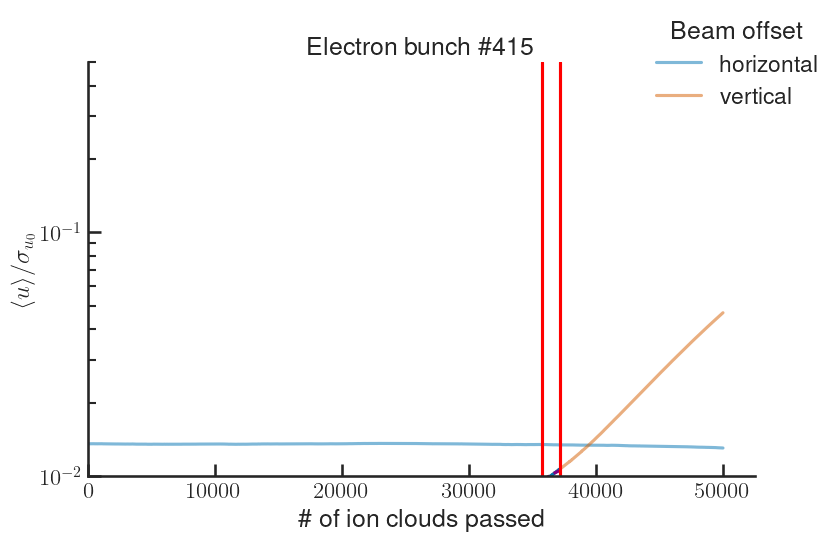

In [13]:
from FIT_FBII import fit_exponential_risetime, fit_sqrt_exponential_risetime, get_envelope
# fig, (ax_el, ax_ions) = plt.subplots(1, 2)
fig, ax_el = plt.subplots(1, 1)
# sigma_y[0] = SIGMA_Y
# sigma_x[0] = SIGMA_X

for ax in (ax_el,):
    ax.set_ylabel('$\langle u \\rangle/\sigma_{u_0}$')
ax_el.set_xlabel('\# of ion clouds passed')
# ax_ions.set_xlabel('\# of electron bunches passed')

    # ax.set_ylim(/-.2, .2)
t = np.linspace(0, 1000, mean_x.shape[0])
# ax_ions.plot((mean_x_ion)/sigma_x[0], color='b', alpha=0.5)
# ax_ions.plot((mean_y_ion)/sigma_y[0], color='r', alpha=0.5)
ax_el.semilogy(np.sqrt(mean_x**2+mean_xp**2*BETA_X_SMOOTH**2)/sigma_x[0], color='b', alpha=0.5, label='horizontal')
ax_el.semilogy(np.sqrt(mean_y**2+mean_yp**2*BETA_Y_SMOOTH**2)/sigma_y[0], color='r', alpha=0.5, label='vertical')
signal = np.sqrt(mean_y**2+(BETA_Y_SMOOTH*mean_yp)**2)/sigma_y[0]
window_size = 35
rx = fit_exponential_risetime(signal,
                              min_level=1.25*np.max(np.abs(signal[:50])), 
                              smoothing_window_size=window_size, 
                              start_from_0=False,
                              matplotlib_axis =None
                             )
rx2 = fit_sqrt_exponential_risetime(signal,
                                    min_level=1.25*np.max(np.abs(signal[:50])),
                                    start_from_0=False,
                                    smoothing_window_size=window_size, 
                                    matplotlib_axis = ax_el
                                   )
print('Risetime computed by exponential fit is {:.2f} turns'.format(rx/25))
print('Risetime computed by exponential of a square root is {:.2f} turns'.format((rx2)**2/25))
print('rx {:.2e}, rx2 {:.2e}'.format(rx, rx2))
# x_envelope, y_envelope = get_envelope(np.arange(len(signal)), signal, window_size=window_size)
# ax_el.plot(x_envelope, y_envelope, marker='.')
# ddt = np.gradient(y_envelope, x_envelope)
# dddt = np.gradient(ddt, x_envelope)
# ax_el.plot(x_envelope, ddt, color='navy')
# ax_el.plot(x_envelope, dddt, color='navy', linestyle='dashed')

# print(x_envelope)
# print(y_envelope)
ax_el.set_ylim(1e-2, .5)
# ax_el.set_xlim(0, 200)
# ax_ions.set_ylim(-1, 1)
# ax_ions.set_xlim(416*2-20, 416*2+20)
# ax_ions.title.set_text('Ions')
# x = np.linspace(100, len(mean_x), len(mean_x)-1)
# y = 0.03*np.exp(np.sqrt(x/400))
# ax_el.plot(x, y, color='black')
ax_el.set_xlim(0,)
ax_el.title.set_text('Electron bunch \#{:}'.format(int(bunch_number)))
plt.figlegend(frameon=False, title='Beam offset')
# fit = 0.002*np.exp(np.sqrt(200*t/(rx2**2)))
# print(fit)
# ax_el.plot(fit)
print(mean_y.shape)
# plt.savefig('Figures/LN_offset.svg')
# plt.savefig('Figures/LN_offset.pdf')

2.1475957e-05 2.1520687721353146e-05
9.925151e-06 9.879676108051316e-06


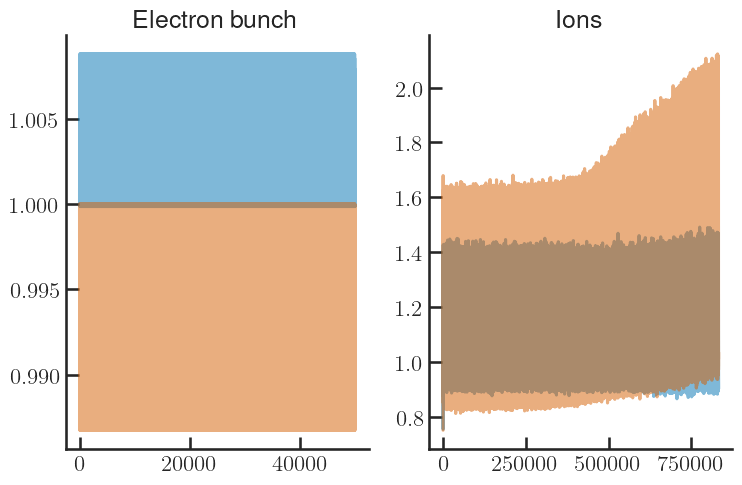

In [14]:
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
# fig, (ax_el, ) = plt.subplots(1, 1)
ax_el.title.set_text('Electron bunch')
ax_ions.title.set_text('Ions')

ax_ions.plot((sigma_x_ion)/sigma_x[0], color='b', label='$\langle x \\rangle$', alpha=0.5)
ax_ions.plot((sigma_y_ion)/sigma_y[0], color='r', label='$\langle y \\rangle$', alpha=0.5)
ax_el.plot(sigma_x/sigma_x[0], color='b', alpha=0.5, label='horizontal')
ax_el.plot(sigma_y/sigma_y[0], color='r', alpha=0.5, label='vertical')
# ax_el.set_ylim(.9, 1.1)
# ax_ions.set_ylim(.5, 3.)
print(sigma_x[0], np.sqrt(EPSILON_X*BETA_X_SMOOTH))
print(sigma_y[0], np.sqrt(EPSILON_Y*BETA_Y_SMOOTH))

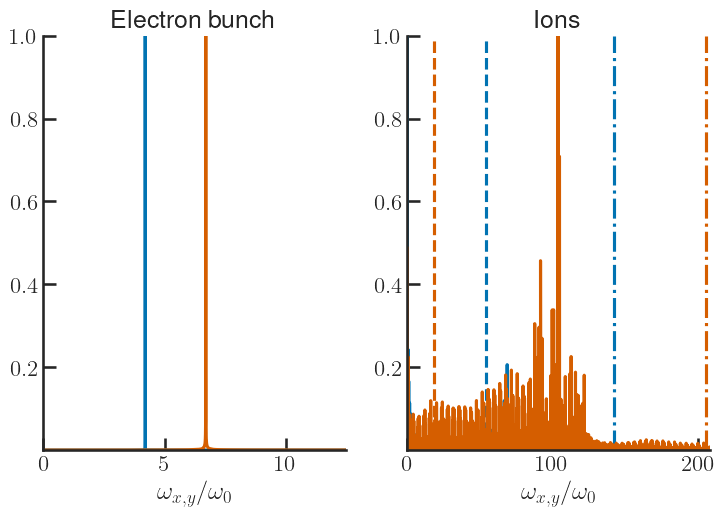

In [15]:
from numpy.fft import rfft, rfftfreq
f_0 = c/CIRCUMFERENCE
N_SEGMENTS = 25
f_s = f_0*N_SEGMENTS
fft_mean_x = np.abs(rfft(mean_x[:]-np.mean(mean_x[:])))
fft_mean_y = np.abs(rfft(mean_y[:]-np.mean(mean_y[:])))

fftfreq_mean_x = f_s*rfftfreq(mean_x[:].shape[0])/f_0
fftfreq_mean_y = f_s*rfftfreq(mean_y[:].shape[0])/f_0
f_s_ions = f_0*416
fft_mean_x_ion = np.abs(rfft(mean_x_ion[:]-np.mean(mean_x_ion[:])))
fft_mean_y_ion = np.abs(rfft(mean_y_ion[:]-np.mean(mean_y_ion[:])))

fftfreq_mean_x_ion = f_s_ions*rfftfreq(mean_x_ion[:].shape[0])/f_0
fftfreq_mean_y_ion = f_s_ions*rfftfreq(mean_y_ion[:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
for ax in (ax_el, ax_ions):
    ax.axvline(Q_Y, color='r', linestyle='dashed')
    ax.axvline(Q_X, color='b', linestyle='dashed')
    ax.set_xlabel('$\omega_{x,y}/\omega_0$')
    ax.axvline(2*omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
    ax.axvline(2*omega_i_y/OMEGA_REV, color='r', linestyle='dashdot')
    ax.set_ylim(1e-3, 1)
ax_el.set_xlim(0, .5*f_s/f_0)
ax_ions.set_xlim(0, 416//2)    
ax_el.plot(fftfreq_mean_x, fft_mean_x/np.max(fft_mean_x))
ax_el.plot(fftfreq_mean_y, fft_mean_y/np.max(fft_mean_y), color='r')

ax_ions.plot(fftfreq_mean_x_ion, fft_mean_x_ion/np.max(fft_mean_x_ion))
ax_ions.plot(fftfreq_mean_y_ion, fft_mean_y_ion/np.max(fft_mean_y_ion), color='r')
ax_el.title.set_text('Electron bunch')
ax_ions.title.set_text('Ions')


[0.0000000e+00 8.3200000e-03 1.6640000e-02 ... 2.0798336e+02 2.0799168e+02
 2.0800000e+02]


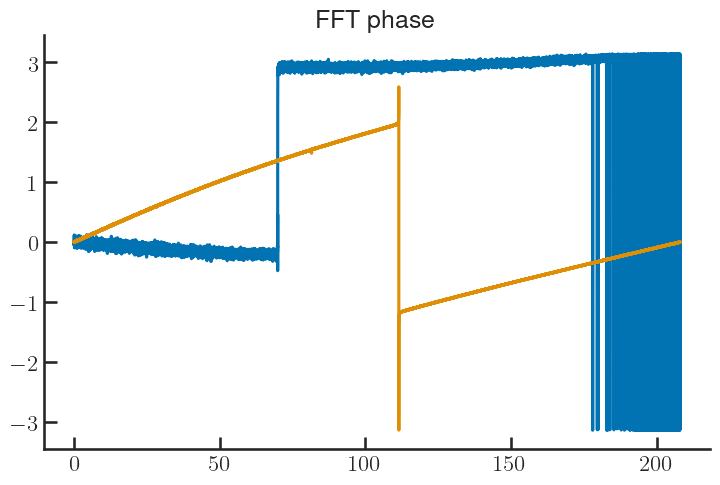

In [16]:
fig, ax = plt.subplots(1, 1)
ax.title.set_text('FFT phase')
fft_x = rfft(mean_x[:]-np.mean(mean_x[:]))
fft_y = rfft(mean_y[:]-np.mean(mean_x[:]))
fft_phase_x = np.angle(fft_x)# np.arctan2(fft_x.real, fft_x.imag)
fft_phase_y = np.angle(fft_y)#np.arctan2(fft_y.real, fft_y.imag)
fftfreq_mean_x = f_s_ions*rfftfreq(mean_x[:].shape[0])/f_0
fftfreq_mean_y = f_s_ions*rfftfreq(mean_y[:].shape[0])/f_0
ax.plot(fftfreq_mean_x, fft_phase_x)
ax.plot(fftfreq_mean_y, fft_phase_y)
print(fftfreq_mean_y)

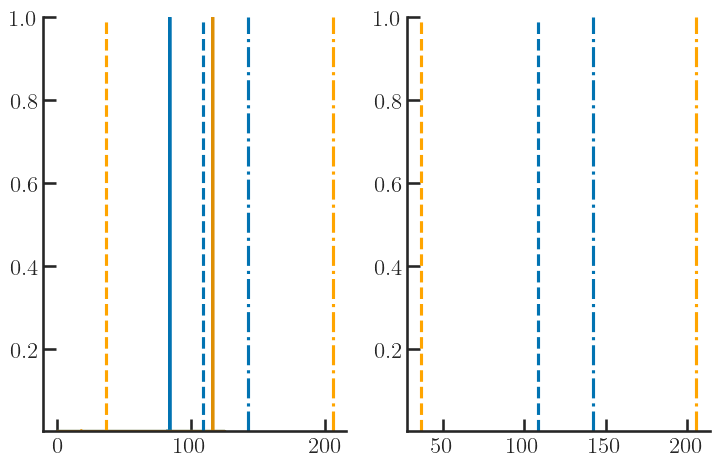

In [17]:
from numpy.fft import rfft, rfftfreq
from scipy.constants import c
CIRCUMFERENCE = 354
f_0 = c/CIRCUMFERENCE
f_s = f_0*250
fft_sigma_x = np.abs(rfft(sigma_x-np.mean(sigma_x)))
fft_sigma_y = np.abs(rfft(sigma_y-np.mean(sigma_y)))

fftfreq_sigma_x = f_s*rfftfreq(sigma_x.shape[0])/f_0
fftfreq_sigma_y = f_s*rfftfreq(sigma_y.shape[0])/f_0
f_s_ions = f_0*416
# fft_sigma_x_ion = np.abs(rfft(sigma_x_ion[100:]-np.mean(sigma_x_ion)))
# fft_sigma_y_ion = np.abs(rfft(sigma_y_ion[100:]-np.mean(sigma_y_ion)))
# fftfreq_sigma_x_ion = f_s_ions*rfftfreq(sigma_x_ion[100:].shape[0])/f_0
# fftfreq_sigma_y_ion = f_s_ions*rfftfreq(sigma_y_ion[100:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
ax_el.plot(fftfreq_sigma_x, fft_sigma_x/np.max(fft_sigma_x))
ax_el.plot(fftfreq_sigma_y, fft_sigma_y/np.max(fft_sigma_y))
# ax_ions.plot(fftfreq_sigma_x_ion, fft_sigma_x_ion/np.max(fft_sigma_x_ion))
# ax_ions.plot(fftfreq_sigma_y_ion, fft_sigma_y_ion/np.max(fft_sigma_y_ion))
for ax in [ax_el, ax_ions]:
    ax.axvline(Q_X*2, color='b', linestyle='dashed')
    ax.axvline(Q_Y*2, color='orange', linestyle='dashed')           
    ax.axvline(2*omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
    ax.axvline(2*omega_i_y/OMEGA_REV, color='orange', linestyle='dashdot')
    ax.set_ylim(1e-3, 1)
    # ax.set_xlim(0, 150)    

In [18]:
n_ion_macroparticles = np.linspace(1, 5*416, int(5*416))
for i in range(len(n_ion_macroparticles)):
    x, xp, y, yp, z, dp =  read_ion_particles(0, i)
    n_ion_macroparticles[i] = x.shape[0]
fig, ax = plt.subplots(1, 1)
ax.plot(n_ion_macroparticles)
ax.set_ylabel('\# of ion macroparticles')
ax.set_xlabel('\# of electron bunches passed by')
ax.set_xlim(0, 5*416)
# ax.set_xticks([0, 104, 208, 312, 416, 520, 624])
# ax.set_ylim(0, int(2e4))
# ax.title.set_text('niform filling')
# np.save('Figures/gaps3_soleil.npy', n_ion_macroparticles)
# plt.savefig('Figures/gaps=3_soleil.svg')
# plt.savefig('Figures/gaps=3_soleil.pdf')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/n_mp=1.0e+04,gap_length=1,n_gaps=4,n_segments=25,int_model=weak,smooth=True/IPM(ind=0).h5part', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

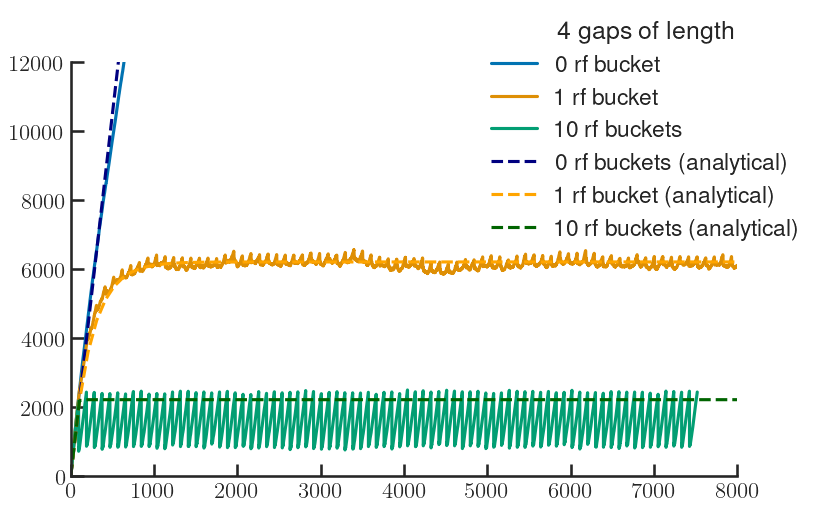

In [43]:
folder_el = '/home/gubaidulin/scripts/tracking/elegant_scripts/ions_example_soleil_ii/'
fig, ax = plt.subplots(1, 1)
label_list = ['0 rf bucket', '1 rf bucket', '10 rf buckets']
for i in [1, 2, 3]:
    file_el = hp.File(folder_el+'ionDens{:}.hdf5'.format(int(i)))
    intensity_el = [0]
    for n in range(1, 200, 10):
        intensity_el = np.concatenate((intensity_el, file_el['page{:}'.format(int(n))]['columns']['nMacroIons'][:]))
    np.save('/home/gubaidulin/scripts/tracking/elegant_scripts/saved_output/elegant_gaps{:.1f}'.format(i), intensity_el)
    ax.plot(5/2*intensity_el, label=label_list[i-1])
    ax.set_xlim(0, 8e3)
    ax.set_ylim(0,1.2e4)
    file_el.close()
# Wang formula
@np.vectorize
def f_ions(n, n_empty=1):
    k = np.linspace(0, n-1, n, dtype=np.int64)
    return .7*30*104*np.sum(np.exp(-k*n_empty*0.85/1.96))
n = np.linspace(0, 80, 80, dtype=np.int64)
ax.plot(n*104, f_ions(n, n_empty=0),  color='navy', label='0 rf buckets (analytical)', linestyle='dashed')
ax.plot(n*104, f_ions(n, n_empty=1),  color='orange', label='1 rf bucket (analytical)', linestyle='dashed')
ax.plot(n*104, f_ions(n, n_empty=10), color='darkgreen', label='10 rf buckets (analytical)', linestyle='dashed')
plt.figlegend(title='4 gaps of length')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/n_mp=1.0e+04,n_mp_ions=1.0e+06,n_gaps=0.0e+00,n_segments=2.5e+01_every_104,int_model=weak/IM(ind=0).h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

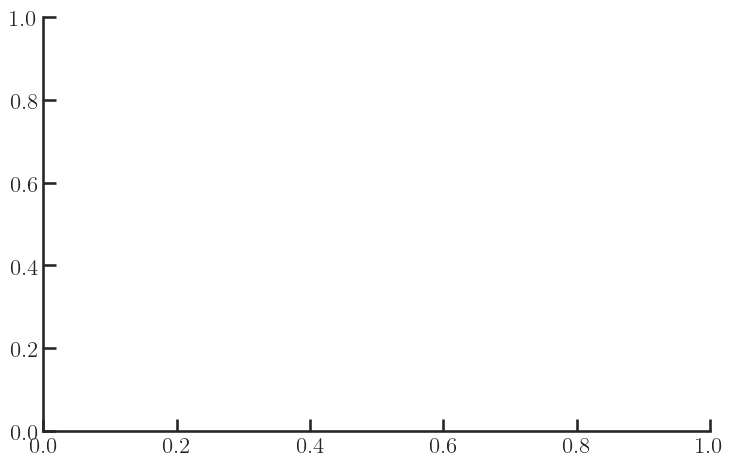

In [45]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(1, 1)
colorblind = sbs.color_palette('colorblind')
colors_el = ['navy', 'darkred', 'darkgreen']
for n in [0, 1, 10]:
    path = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/'
    intensity_el = 5/2*np.load('/home/gubaidulin/scripts/tracking/elegant_scripts/saved_output/elegant_gaps={:}.npy'.format(int(n)))
    if n!=10:
        folder = 'n_mp={:.1e},n_mp_ions={:.1e},n_gaps={:.1e},n_segments={:.1e}_every_104,int_model=weak/'.format(n_macroparticles, n_macroparticles_ions, n, n_segments)
        filename=path+folder+'IM(ind=0).h5'
        file = hp.File(filename)
        intensity = file['Bunch']['macroparticlenumber'][:]
        file.close()
        c_ind=n
        ax.plot(intensity[:8000], label='{:} rf buckets'.format(int(n)), color=colorblind[c_ind])
        
    else:
        c_ind = 2
        intensity = np.load('/home/gubaidulin/intensity_pyht_gaps=10.npy')
        ax.plot(intensity[:], label='{:} rf buckets'.format(int(n)), color=colorblind[c_ind])        
    ax.plot(intensity_el, label='{:} rf buckets (elegant)'.format(int(n)), color=colors_el[c_ind], alpha=0.8)
    
ax.title.set_text('Gaps in SOLEIL II')
ax.set_xlabel('Number of passed electron bunches')
ax.set_ylabel('Ion intensity (arb. units)')
# ax.xaxis.set_major_locator(MultipleLocator(416))
# ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_xlim(0, 8e3)
ax.set_ylim(0,1.2e4)
plt.figlegend(loc='upper right')
# plt.savefig('/home/gubaidulin/gaps_in_soleilII.pdf')
# plt.savefig('/home/gubaidulin/gaps_in_soleilII.svg')

58854.711268252795
547045595.6312125


/tmp/ipykernel_36821/143587981.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return 2*Q_y*omega_0/(n**2*omega_e**2*omega_i*L_sep/c)


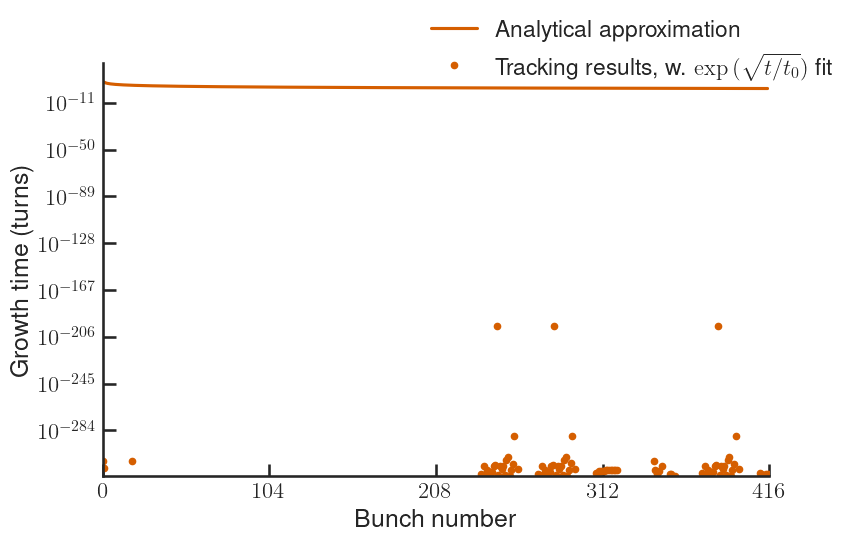

In [46]:
fig, ax = plt.subplots(1, 1)
def get_t_of_bunch_n(n, omega_e, omega_i, omega_0, L_sep=0.85, Q_y=18.2):
    return 2*Q_y*omega_0/(n**2*omega_e**2*omega_i*L_sep/c)
n = np.linspace(0, 415, 416)
# omega_e_y = 63093.07877837223
# omega_i_y = 170579231.140797
print(omega_e_y)
print(omega_i_y)
t = get_t_of_bunch_n(n, omega_e_y, omega_i_y, OMEGA_REV,  L_sep=L_sep, Q_y=Q_Y)
ax.semilogy(n, t*2*pi*OMEGA_REV, color='r', label='Analytical approximation')
# ax.semilogy(risetime_exonential[:-50], linewidth=0, marker='.', color='b', label='Tracking results, w. $\exp{(t/t_0)}$ fit')
ax.semilogy(risetime_sqrt[:], linewidth=0, marker='.', label='Tracking results, w. $\exp{(\sqrt{t/t_0})}$ fit', color='r')
ax.set_xticks([0, 104, 208, 312, 416])
ax.set_xlim(0, 416)
ax.set_xlabel('Bunch number')
ax.set_ylabel('Growth time (turns)')
plt.figlegend()
# plt.savefig('Figures/Growthtimes_comparison.svg')
# plt.savefig('Figures/Growthtimes_comparison.pdf')

In [47]:
x, xp, y, yp, z, dp =  read_ion_particles(0, 0)
fig, axlist = plt.subplots(1, 2)
print(x.shape, xp.shape)
shape = np.min([x.shape[0], y.shape[0], xp.shape[0], yp.shape[0]])
x=x[:shape]
xp=xp[:shape]

y=y[:shape]
yp=yp[:shape]

axlist[0].scatter(x/sigma_x[0], xp*c/omega_i_x/sigma_x[0], alpha=0.05, color='b', marker='.')
# sbs.kdeplot(x/sigma_x[0], xp*c/omega_i_x/sigma_x[0], color='b', ax = axlist[0], levels=10)
axlist[1].scatter(y/sigma_y[0], yp*c/omega_i_y/sigma_y[0], alpha=0.05, color='r', marker='.')
# sbs.kdeplot(y/sigma_y[0], yp*c/omega_i_y/sigma_y[0], color='r', ax=axlist[1], levels=10)

print(x.shape)
axlist[0].set_xlabel('Horizontal position, $x/\sigma_{e_x}$')
axlist[0].set_ylabel('Horizontal momentum, $p_x$ (arb. units)')
axlist[1].set_xlabel('Vertical position, $y/\sigma_{e_y}$')
axlist[1].set_ylabel('Vertical momentum, $p_y$ (arb. units)')

for ax in axlist:
    # ax.set_xlim(-5, 5)
    # ax.set_ylim(-1e-23, 1e-23)
    pass
plt.savefig('Figures/transverse_phase_space.svg')
plt.savefig('Figures/transverse_phase_space.pdf')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/n_mp=1.0e+04,n_mp_ions=1.0e+06,gap_length=1.0e+00,n_gaps=4,n_segments=2.5e+01,int_model=strong,smooth=True/IPM(ind=0).h5part', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/home/gubaidulin/scripts/tracking/fbii_pyht_tracking/Results/TDR/n_mp=1.0e+04,n_mp_ions=1.0e+06,gap_length=1.0e+00,n_gaps=4,n_segments=2.5e+01,int_model=strong,smooth=True/IPM(ind=0).h5part', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

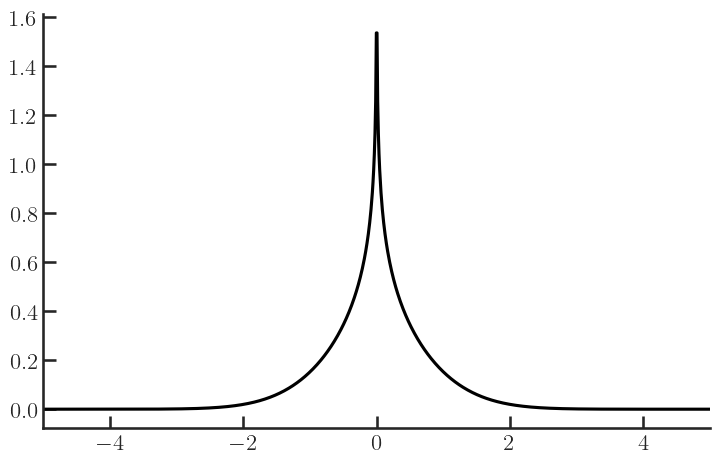

In [48]:
from scipy.special import k0
fig, ax = plt.subplots(1, 1)
def get_dist(x, sig_x):
    return 1/(pi*np.sqrt(2*pi)*sig_x)*k0(x**2/(2*sig_x)**2)*np.exp(-x**2/(2*sig_x)**2)
ax.set_xlim(-5, 5)
x = np.linspace(-5, 5, 1000)
y = get_dist(x, 1)
ax.plot(x, y, linestyle='solid', label='Analytical (P.F. Tavares)', color='black')
for i in range(500, 501, 2):
    x, xp, y, yp, z, dp =  read_ion_particles(0, i)
    ax = sbs.kdeplot((x-np.mean(x))/sigma_x[0],  alpha=1, color='b')
    ax = sbs.kdeplot((y-np.mean(y))/sigma_y[0],  alpha=1, color='r')
ax.set_xlabel('$u/\sigma_u$')
plt.savefig('Figures/distribution_ions.svg')
plt.savefig('Figures/distribution_ions.pdf')
# plt.xlim(-5, 5)
# plt.ylim(0, )
# plt.title("Analytical distribution (Tavares)")
# plt.savefig('Figures/distribution_tavares.svg')
# plt.savefig('Figures/distribution_tavares.pdf')